# Predict demographics from chest x-rays

## Imports and setup

In [5]:
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import os
import random
import glob

/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

In [6]:
# Set seeds

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [7]:
device = torch.device( "mps" if torch.backends.mps.is_available() else "cpu")

## Load data

In [8]:
# Clean dataframe

df = pd.read_csv('../data/NIH_Chest_Full/Data_Entry_2017_v2020.csv')

# Dropping NAs in sex and age
df = df.dropna(subset=["Patient Sex", "Patient Age"])

# Map sex to binary
df['Patient Sex'] = df['Patient Sex'].map({"M": 1, "F": 0})

# Bin age
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_centers = [10, 25, 35, 45, 55, 65, 75, 85, 95]
# Non-inclusive - age 20 is in first bin not second
df["AgeBin"] = pd.cut(df["Patient Age"], bins=age_bins, labels=False)
df["BinCenter"] = df["AgeBin"].apply(lambda x: bin_centers[int(x)] if pd.notnull(x) else np.nan)
df = df.dropna(subset=['AgeBin'])

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],AgeBin,BinCenter
0,00000001_000.png,Cardiomegaly,0,1,57,1,PA,2682,2749,0.143,0.143,4.0,55.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,1,PA,2894,2729,0.143,0.143,4.0,55.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,1,PA,2500,2048,0.168,0.168,4.0,55.0
3,00000002_000.png,No Finding,0,2,80,1,PA,2500,2048,0.171,0.171,6.0,75.0
4,00000003_001.png,Hernia,0,3,74,0,PA,2500,2048,0.168,0.168,6.0,75.0


In [9]:
# Add full image path to dataframe

image_dirs = glob.glob('../data/NIH_Chest_Full/images_*/images/')
image_map = {}
for d in image_dirs:
    for f in os.listdir(d):
        if f.endswith(".png"):
            image_map[f] = os.path.join(d, f)

df["Path"] = df["Image Index"].map(image_map)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],AgeBin,BinCenter,Path
0,00000001_000.png,Cardiomegaly,0,1,57,1,PA,2682,2749,0.143,0.143,4.0,55.0,../data/NIH_Chest_Full/images_001/images/00000...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,1,PA,2894,2729,0.143,0.143,4.0,55.0,../data/NIH_Chest_Full/images_001/images/00000...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,1,PA,2500,2048,0.168,0.168,4.0,55.0,../data/NIH_Chest_Full/images_001/images/00000...
3,00000002_000.png,No Finding,0,2,80,1,PA,2500,2048,0.171,0.171,6.0,75.0,../data/NIH_Chest_Full/images_001/images/00000...
4,00000003_001.png,Hernia,0,3,74,0,PA,2500,2048,0.168,0.168,6.0,75.0,../data/NIH_Chest_Full/images_001/images/00000...


In [10]:
# Split per patient
from sklearn.model_selection import GroupShuffleSplit

split = GroupShuffleSplit(test_size=0.2, random_state=42, n_splits=1)
train_idx, val_idx = next(split.split(df, groups=df["Patient ID"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print("Train set size:", len(train_df))
print("Val set size", len(val_df))

Train set size: 89898
Val set size 22208


In [11]:
# Check class imbalance

print(train_df['AgeBin'].value_counts())

AgeBin
4.0    22107
3.0    17951
5.0    13994
2.0    13599
1.0    10575
0.0     6522
6.0     4480
7.0      639
8.0       31
Name: count, dtype: int64


In [12]:
# Add oversampling for rare bins in train set

from torch.utils.data import WeightedRandomSampler

# Create weights per sample
age_counts = train_df['AgeBin'].value_counts().sort_index()
num_bins = 9
age_counts = age_counts.reindex(range(num_bins), fill_value=1)
weights_per_bin = 1.0 / age_counts
sample_weights = train_df['AgeBin'].apply(lambda x: weights_per_bin.loc[int(x)])

sampler = WeightedRandomSampler(
    weights=sample_weights.values,
    num_samples=len(sample_weights),
    replacement=True
)

In [13]:
from dataset import DemographicDataset

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_ds = DemographicDataset(
    train_df,
    transform=transform
)

val_ds = DemographicDataset(
    val_df,
    transform=transform
)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

## Train model

In [14]:
class DemographicModel(nn.Module):
    def __init__(self, backbone=None):
        super().__init__()

        # Pre-trained DenseNet121 from torchvision
        if backbone is None:
            base = models.densenet121(pretrained=True)
            self.feature_extractor = nn.Sequential(*list(base.features.children()))
            feature_dim = 1024 # final DenseNet121 feature size
        else:
            self.feature_extractor = backbone.features
            feature_dim = backbone.features.denseblock4.denselayer16.norm2.num_features

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)

        # task heads
        self.age_head = nn.Linear(feature_dim, 1) # Regression for continuous age
        self.sex_head = nn.Linear(feature_dim, 1) # Binary classification

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)

        age_pred = self.age_head(x).squeeze(1)
        sex_prob = torch.sigmoid(self.sex_head(x)) # binary

        return age_pred, sex_prob

In [12]:
# Use class weights for age loss

age_counts = train_df['AgeBin'].value_counts().sort_index()
total = age_counts.sum()
class_weights = total / (len(age_counts) * age_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

In [18]:
def multi_task_metrics(age_preds, age_targets, sex_probs, sex_targets):

    # Losses
    age_loss = F.mse_loss(age_preds, age_targets)
    sex_loss = F.binary_cross_entropy(sex_probs.view(-1), sex_targets.float())
    total_loss = age_loss + sex_loss

    # Classification accuracy
    acc_sex = (sex_probs.view(-1) >= 0.5).eq(sex_targets).float().mean().item()

    # Regression MAE
    mae_age = F.l1_loss(age_preds, age_targets).item()

    loss_dict = {
        "age": age_loss.item(),
        "sex": sex_loss.item()
    }

    acc_dict = {
        "age_mae": mae_age,
        "sex": acc_sex
    }

    return total_loss, loss_dict, acc_dict

In [24]:
def train(model, dataloader, optimizer, device):
    model.train()
    n_batches = 0
    losses = {"age": 0, "sex": 0}
    metrics = {"age_mae": 0, "sex": 0}
    total_loss = 0

    for images, age_bin, sex, age_true in tqdm(dataloader):
        images = images.to(device)
        age_true = age_true.to(device)
        sex = sex.to(device)

        optimizer.zero_grad()
        age_logits, sex_probs= model(images)
        loss, loss_dict, acc_dict = multi_task_metrics(
            age_logits, age_true, sex_probs, sex
        )
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for k in losses:
            losses[k] += loss_dict[k]
        for k in metrics:
            metrics[k] += acc_dict[k]
        n_batches += 1

    # average over batches
    for k in losses:
        losses[k] /= n_batches
    for k in metrics:
        metrics[k] /= n_batches

    return total_loss / n_batches, losses, metrics

In [27]:
from sklearn.metrics import roc_auc_score, mean_absolute_error, root_mean_squared_error, r2_score

def evaluate(model, dataloader, device):
    model.eval()
    n_batches = 0

    losses = {"age": 0, "sex": 0}
    metrics = {"age_mae": 0,"sex": 0}
    total_loss = 0

    # store all predictions and labels for AUC
    all_probs = {"sex": []}
    all_targets = {"sex": []}
    all_preds = []
    all_actuals = []

    with torch.no_grad():
        for images, age_bin, sex, age_true in dataloader:
            images = images.to(device)
            age_bin = age_bin.to(device)
            sex = sex.to(device)
            age_true = age_true.to(device)

            age_preds, sex_probs = model(images)

            # Save age preds and targets
            all_preds.append(age_preds.cpu())
            all_actuals.append(age_true.cpu())

            loss, loss_dict, acc_dict = multi_task_metrics(
                age_preds, age_true, sex_probs, sex
            )
            
            total_loss += loss.item()
            for k in losses:
                losses[k] += loss_dict[k]
            for k in metrics:
                metrics[k] += acc_dict[k]

            # Save probabilities and targets for AUC
            all_probs["sex"].extend(sex_probs.view(-1).cpu().numpy())
            all_targets["sex"].extend(sex.cpu().numpy())

            n_batches += 1

    for k in losses:
        losses[k] /= n_batches
    for k in metrics:
        metrics[k] /= n_batches

    # compute AUCs
    aucs = {}
    for k in ["sex"]:
        try:
            auc = roc_auc_score(all_targets[k], all_probs[k])
        except ValueError:
            auc = float("nan") # AUC not computable if only 1 class present (e.g. during early epochs)
        aucs[k] = auc

    # compute MAE and RMSE
    predicted_ages = torch.cat(all_preds)
    true_ages = torch.cat(all_actuals)
    pred_np = predicted_ages.numpy()
    true_np = true_ages.numpy()
    mae = mean_absolute_error(true_np, pred_np)
    rmse = root_mean_squared_error(true_np, pred_np)
    r2 = r2_score(true_np, pred_np)

    return total_loss / n_batches, losses, metrics, aucs, mae, rmse, r2

In [28]:
model = DemographicModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs=10
best_r2 = -float("inf")

history = {
    "train_loss": [],
    "train_loss_per_task": [],
    "val_loss": [],
    "val_loss_per_task": [],
    "train_acc_sex": [],
    "val_acc_sex": [],
    "val_auc_sex": [],
    "train_mae_age": [],
    "val_mae_age": [],
    "val_rmse_age": [],
    "val_r2_age": []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_losses, train_metrics = train(model, train_loader, optimizer, device)
    val_loss, val_losses, val_metrics, val_aucs, val_mae, val_rmse, r2 = evaluate(
        model, val_loader, device
    )

    if r2 > best_r2:
        best_r2 = r2
        torch.save(model.state_dict(), 'demographic_model.pt')

    print(f"Train Loss: {train_loss:.4f}")
    print("Train Task Losses:", train_losses)
    print("Train Metrics:  ", train_metrics)

    print(f"Val Loss: {val_loss:.4f}")
    print("Val Task Losses: ", val_losses)
    print("Val Metrics:", val_metrics)
    print("Val AUC: ", val_aucs)
    print(f"Val MAE (age): {val_mae:.2f}")
    print(f"Val RMSE (age): {val_rmse:.2f}")
    print(f"Val R^2 (age): {r2:.3f}")

    history["train_loss"].append(train_loss)
    history["train_loss_per_task"].append(train_losses)
    history["val_loss"].append(val_loss)
    history["val_loss_per_task"].append(val_losses)

    history["train_acc_sex"].append(train_metrics["sex"])
    history["val_acc_sex"].append(val_metrics["sex"])

    history["val_auc_sex"].append(val_aucs["sex"])
    history["train_mae_age"].append(train_metrics["age_mae"])
    history["val_mae_age"].append(val_mae)
    history["val_rmse_age"].append(val_rmse)
    history["val_r2_age"].append(r2)

/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 746.2793
Train Task Losses: {'age': 745.6582375183649, 'sex': 0.6211024531478135}
Train Metrics:   {'age_mae': 20.347924501361373, 'sex': 0.6566770462591028}
Val Loss: 59.0037
Val Task Losses:  {'age': 58.45871188111539, 'sex': 0.5449580395170179}
Val Metrics: {'age_mae': 5.930121812765468, 'sex': 0.7685068443804035}
Val AUC:  {'sex': np.float64(0.9054344226706026)}
Val MAE (age): 5.93
Val RMSE (age): 7.65
Val R^2 (age): 0.794

Epoch 2/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 54.8805
Train Task Losses: {'age': 54.41673101954613, 'sex': 0.46373739541637515}
Train Metrics:   {'age_mae': 5.766051079454796, 'sex': 0.8004670818505338}
Val Loss: 56.6293
Val Task Losses:  {'age': 56.27670500463986, 'sex': 0.35255080925284615}
Val Metrics: {'age_mae': 5.805850303825796, 'sex': 0.8805835734870316}
Val AUC:  {'sex': np.float64(0.9553444599947452)}
Val MAE (age): 5.81
Val RMSE (age): 7.50
Val R^2 (age): 0.802

Epoch 3/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 46.9848
Train Task Losses: {'age': 46.64261416065311, 'sex': 0.34218848526371753}
Train Metrics:   {'age_mae': 5.358576432156817, 'sex': 0.8580604982333675}
Val Loss: 55.6882
Val Task Losses:  {'age': 55.43800723071744, 'sex': 0.2501605822133056}
Val Metrics: {'age_mae': 5.754204144395394, 'sex': 0.9182726945244957}
Val AUC:  {'sex': np.float64(0.9731202139244342)}
Val MAE (age): 5.75
Val RMSE (age): 7.45
Val R^2 (age): 0.805

Epoch 4/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 43.6362
Train Task Losses: {'age': 43.37045904071306, 'sex': 0.2657511972394702}
Train Metrics:   {'age_mae': 5.182092065828127, 'sex': 0.8907339857778516}
Val Loss: 47.4549
Val Task Losses:  {'age': 47.27123062411371, 'sex': 0.18366396322213005}
Val Metrics: {'age_mae': 5.278123281874643, 'sex': 0.9318263688760807}
Val AUC:  {'sex': np.float64(0.9820818819020789)}
Val MAE (age): 5.28
Val RMSE (age): 6.88
Val R^2 (age): 0.834

Epoch 5/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 40.2371
Train Task Losses: {'age': 40.003478532499265, 'sex': 0.23358133744673798}
Train Metrics:   {'age_mae': 4.993164530258586, 'sex': 0.9053603202846975}
Val Loss: 54.9330
Val Task Losses:  {'age': 54.760057214357666, 'sex': 0.17298770532339425}
Val Metrics: {'age_mae': 5.728615495244776, 'sex': 0.9370947406340058}
Val AUC:  {'sex': np.float64(0.9837238320039758)}
Val MAE (age): 5.73
Val RMSE (age): 7.40
Val R^2 (age): 0.807

Epoch 6/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 38.9758
Train Task Losses: {'age': 38.762848006618405, 'sex': 0.2129179768529439}
Train Metrics:   {'age_mae': 4.9139655780113465, 'sex': 0.9139234875444839}
Val Loss: 44.1460
Val Task Losses:  {'age': 43.98602617645813, 'sex': 0.15992412638651898}
Val Metrics: {'age_mae': 5.161512368694162, 'sex': 0.9379052593659942}
Val AUC:  {'sex': np.float64(0.9868484089767607)}
Val MAE (age): 5.16
Val RMSE (age): 6.63
Val R^2 (age): 0.845

Epoch 7/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 37.7130
Train Task Losses: {'age': 37.515029742624414, 'sex': 0.19794854459707423}
Train Metrics:   {'age_mae': 4.848468172507778, 'sex': 0.9203514234875445}
Val Loss: 47.4956
Val Task Losses:  {'age': 47.34697972250947, 'sex': 0.14866893690130445}
Val Metrics: {'age_mae': 5.2917806580018585, 'sex': 0.9421379682997119}
Val AUC:  {'sex': np.float64(0.987103353241464)}
Val MAE (age): 5.29
Val RMSE (age): 6.88
Val R^2 (age): 0.833

Epoch 8/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 36.2310
Train Task Losses: {'age': 36.051463888378755, 'sex': 0.17956708283677325}
Train Metrics:   {'age_mae': 4.756861773377212, 'sex': 0.9279114768810544}
Val Loss: 45.7865
Val Task Losses:  {'age': 45.652968315981994, 'sex': 0.13357067730288513}
Val Metrics: {'age_mae': 5.177664812085264, 'sex': 0.9477215417867435}
Val AUC:  {'sex': np.float64(0.9891556420511091)}
Val MAE (age): 5.18
Val RMSE (age): 6.76
Val R^2 (age): 0.839

Epoch 9/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 33.2005
Train Task Losses: {'age': 33.0300835706161, 'sex': 0.1704652588562609}
Train Metrics:   {'age_mae': 4.558973310341615, 'sex': 0.9319928825750046}
Val Loss: 45.0985
Val Task Losses:  {'age': 44.97263007067809, 'sex': 0.1259113131335907}
Val Metrics: {'age_mae': 5.120145191720308, 'sex': 0.9499279538904899}
Val AUC:  {'sex': np.float64(0.9909050570250231)}
Val MAE (age): 5.12
Val RMSE (age): 6.71
Val R^2 (age): 0.842

Epoch 10/10


  0%|          | 0/2810 [00:00<?, ?it/s]/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/reid-attack/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, th

Train Loss: 33.4947
Train Task Losses: {'age': 33.33512585969158, 'sex': 0.159583343016282}
Train Metrics:   {'age_mae': 4.580872781930021, 'sex': 0.9369328291814947}
Val Loss: 47.5608
Val Task Losses:  {'age': 47.42798915307872, 'sex': 0.1328281889091211}
Val Metrics: {'age_mae': 5.281442279602677, 'sex': 0.947136167146974}
Val AUC:  {'sex': np.float64(0.9893220797957443)}
Val MAE (age): 5.28
Val RMSE (age): 6.89
Val R^2 (age): 0.833


## Visualize

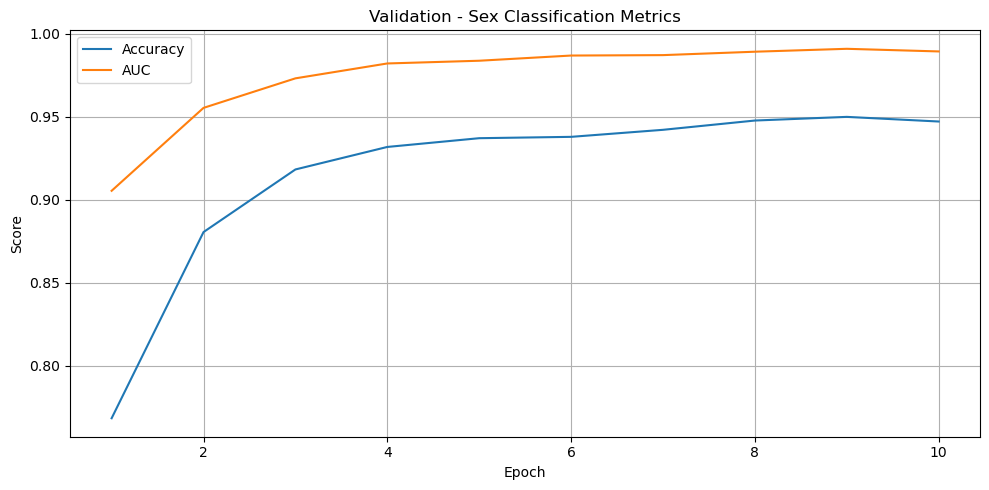

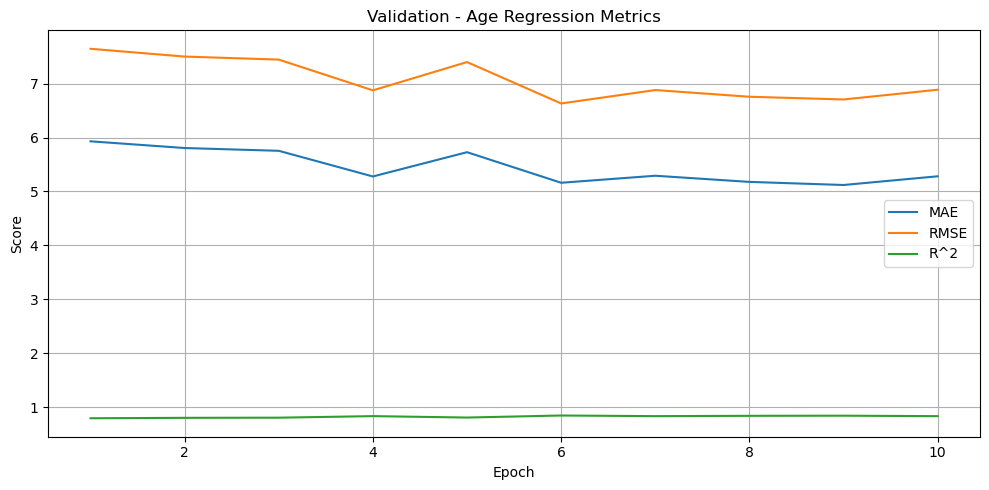

In [29]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

# Plot sex classification
plt.figure(figsize=(10, 5))
plt.plot(epochs, history["val_acc_sex"], label="Accuracy")
plt.plot(epochs, history["val_auc_sex"], label="AUC")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation - Sex Classification Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot age regression
plt.figure(figsize=(10, 5))
plt.plot(epochs, history["val_mae_age"], label="MAE")
plt.plot(epochs, history["val_rmse_age"], label="RMSE")
plt.plot(epochs, history["val_r2_age"], label="R^2")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation - Age Regression Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Results

In [44]:
# Testing for single image from validation set

# Get batch
images, agebin_labels, sex_labels, true_ages = next(iter(val_loader))

# Pick one sample
image = images[1].unsqueeze(0).to(device)
sex_label = sex_labels[1].item()
true_age = true_ages[1].item()

# Run through model
model.eval()
with torch.no_grad():
    age_pred, sex_logits = model(image)
    age_pred = age_pred.item()
    sex_pred = torch.sigmoid(sex_logits).item() > 0.65

# Decode
sex_map = {0.0: "Female", 1.0: "Male"}
pred_sex = "Male" if sex_pred else "Female"
true_sex = sex_map.get(sex_label, "Unknown")

print(f"Predicted age: {age_pred:.1f} vs. Ground truth age: {true_age:.1f}")
print(f"Predicted sex: {pred_sex} vs. Ground truth sex: {true_sex}")

Predicted age: 60.8 vs. Ground truth age: 68.0
Predicted sex: Female vs. Ground truth sex: Female


In [ ]:
# Predicting for entire validation set
import pandas as pd

model.eval()
predictions = []

all_true_ages = []
all_pred_ages = []

with torch.no_grad():
    for images, age_bins, sex_labels, true_ages in val_loader:
        images = images.to(device)
        true_ages = true_ages.to(device)

        # Run model
        age_preds, sex_logits = model(images)

        sex_probs = torch.sigmoid(sex_logits.view(-1))
        sex_preds = (sex_probs > 0.65).long()

        for i in range(images.size(0)):
            pred_age = age_preds[i].item()
            true_age = true_ages[i].item()
            pred_sex = "Male" if sex_preds[i].item() == 1 else "Female"
            true_sex = "Male" if sex_labels[i].item() == 1 else "Female"
            sex_conf = float(sex_probs[i].item())

            predictions.append({
                "PredictedAge": pred_age,
                "TrueAge": true_age,
                "AbsoluteError": abs(pred_age - true_age),
                "PredictedSex": pred_sex,
                "TrueSex": true_sex,
                "SexConfidence": sex_conf
            })

# Create dataframe
results_df = pd.DataFrame(predictions)

# Show sample
results_df.head()

,PredictedAge,TrueAge,AbsoluteError,PredictedSex,TrueSex,SexConfidence
0,76.932083,82.0,5.067917,Male,Male,0.730987
1,60.810730,68.0,7.189270,Female,Female,0.500010
2,64.533279,70.0,5.466721,Female,Female,0.500124
3,66.547943,72.0,5.452057,Female,Female,0.501175
4,71.268768,75.0,3.731232,Male,Male,0.729667


In [42]:
# Finding the optimal threshold for sex classification
from sklearn.metrics import f1_score, accuracy_score

thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    preds = (results_df["SexConfidence"] > t).astype(int)
    true = results_df["TrueSex"].map({"Male": 1, "Female": 0})
    f1 = f1_score(true, preds)
    acc = accuracy_score(true, preds)
    print(f"Threshold {t:.2f} → F1: {f1:.3f}, Accuracy: {acc:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f} (F1 = {best_f1:.3f})")

Threshold 0.10 → F1: 0.714, Accuracy: 0.555
Threshold 0.15 → F1: 0.714, Accuracy: 0.555
Threshold 0.20 → F1: 0.714, Accuracy: 0.555
Threshold 0.25 → F1: 0.714, Accuracy: 0.555
Threshold 0.30 → F1: 0.714, Accuracy: 0.555
Threshold 0.35 → F1: 0.714, Accuracy: 0.555
Threshold 0.40 → F1: 0.714, Accuracy: 0.555
Threshold 0.45 → F1: 0.714, Accuracy: 0.555
Threshold 0.50 → F1: 0.714, Accuracy: 0.555
Threshold 0.55 → F1: 0.935, Accuracy: 0.924
Threshold 0.60 → F1: 0.950, Accuracy: 0.943
Threshold 0.65 → F1: 0.952, Accuracy: 0.948
Threshold 0.70 → F1: 0.934, Accuracy: 0.930
Threshold 0.75 → F1: 0.000, Accuracy: 0.445
Threshold 0.80 → F1: 0.000, Accuracy: 0.445
Threshold 0.85 → F1: 0.000, Accuracy: 0.445
Best threshold: 0.65 (F1 = 0.952)


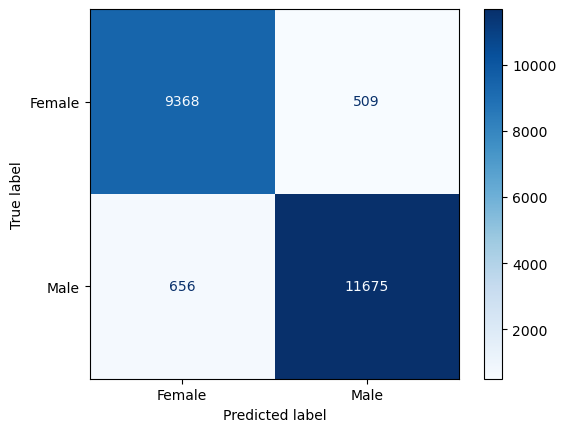

In [46]:
# Plot confusion matrices for sex classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predicted and true labels to arrays
true_sex_labels = [1 if p["TrueSex"] == "Male" else 0 for p in predictions]
pred_sex_labels = [1 if p["PredictedSex"] == "Male" else 0 for p in predictions]

cm = confusion_matrix(true_sex_labels, pred_sex_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap="Blues")

Computing cohort statistics for validation set; comparing distributions between ground truth and predictions

Ground Truth Sex Distribution (%):
 TrueSex
Male      55.525036
Female    44.474964
Name: proportion, dtype: float64

Predicted Sex Distribution (%):
 PredictedSex
Male      54.863112
Female    45.136888
Name: proportion, dtype: float64


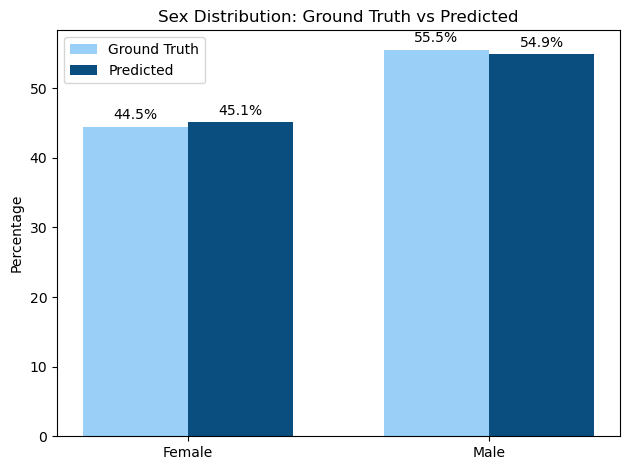

In [ ]:
# Sex

# Ground truth
gt_sex_dist = results_df["TrueSex"].value_counts(normalize=True) * 100
# Predicted
pred_sex_dist = results_df["PredictedSex"].value_counts(normalize=True) * 100

print("Ground Truth Sex Distribution (%):\n", gt_sex_dist)
print("\nPredicted Sex Distribution (%):\n", pred_sex_dist)

# Categories
labels = ["Female", "Male"]

# Values
gt_values = gt_sex_dist.loc[labels].values
pred_values = pred_sex_dist.loc[labels].values

# Bar width and positions
x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

# Colors
color_gt = "#9AD0F7"
color_pred = "#094E7F"

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, gt_values, width, label='Ground Truth', color=color_gt)
bars2 = ax.bar(x + width/2, pred_values, width, label='Predicted', color=color_pred)

ax.set_ylabel('Percentage')
ax.set_title('Sex Distribution: Ground Truth vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

Ground Truth Age Distribution (%):
 True Age Bin
(0, 10]       1.873199
(10, 20]      5.034222
(20, 30]     13.387068
(30, 40]     14.265130
(40, 50]     19.056196
(50, 60]     24.117435
(60, 70]     15.958213
(70, 80]      5.583573
(80, 90]      0.720461
(90, 100]     0.004503
Name: proportion, dtype: float64

Predicted Age Distribution (%):
 Predicted Age Bin
(0, 10]       1.310339
(10, 20]      3.759906
(20, 30]     10.036924
(30, 40]     14.918048
(40, 50]     18.831052
(50, 60]     23.369957
(60, 70]     20.825829
(70, 80]      6.461635
(80, 90]      0.486311
(90, 100]     0.000000
Name: proportion, dtype: float64


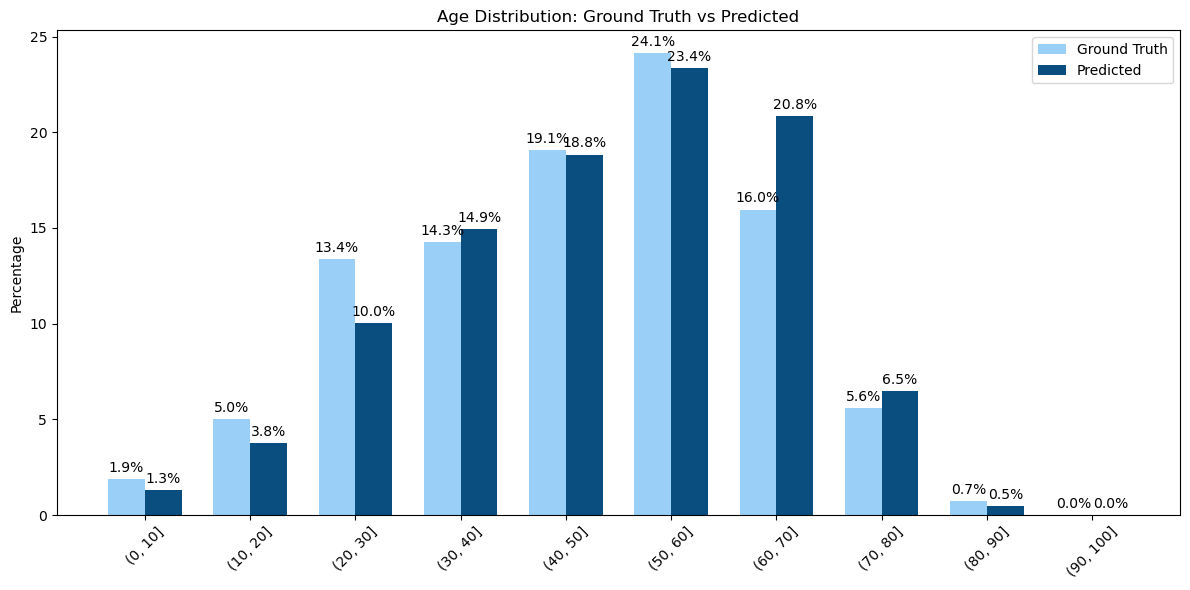

In [56]:
# Age

# Binning for age
bins = np.arange(0, 101, 10)  # 0–10, 10–20, ..., 90–100
results_df["True Age Bin"] = pd.cut(results_df["TrueAge"], bins=bins)
results_df["Predicted Age Bin"] = pd.cut(results_df["PredictedAge"], bins=bins)

# Compute percentage per bin
true_age_dist = results_df["True Age Bin"].value_counts(normalize=True).sort_index() * 100
pred_age_dist = results_df["Predicted Age Bin"].value_counts(normalize=True).sort_index() * 100

print("Ground Truth Age Distribution (%):\n", true_age_dist)
print("\nPredicted Age Distribution (%):\n", pred_age_dist)

# Labels
labels = true_age_dist.index.astype(str)
x = np.arange(len(labels))
width = 0.35

# Colors
color_gt = "#9AD0F7"
color_pred = "#094E7F"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, true_age_dist.values, width, label='Ground Truth', color=color_gt)
bars2 = ax.bar(x + width/2, pred_age_dist.values, width, label='Predicted', color=color_pred)

ax.set_ylabel("Percentage")
ax.set_title("Age Distribution: Ground Truth vs Predicted")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Statistical tests

Comparing statistical differences between predicted vs. true distributions

- Chi-square - sex (categorical)
- KS test and Wasserstein distance - age (ordinal)
- t-test - age mean/median

In [57]:
# Chi-square for sex distribution

from scipy.stats import chi2_contingency

# Contingency table: rows = [True, Predicted], cols = [Female, Male]
sex_counts = pd.crosstab(index=results_df["TrueSex"], columns=results_df["PredictedSex"])
chi2, p, dof, expected = chi2_contingency(sex_counts)

print(f"Chi-square p-value (sex): {p:.4f}")

Chi-square p-value (sex): 0.0000


In [59]:
# KS test for age

from scipy.stats import ks_2samp

ks_stat, p_val = ks_2samp(results_df["TrueAge"], results_df["PredictedAge"])
print(f"KS test p-value (age): {p_val:.4f}")

KS test p-value (age): 0.0000


In [60]:
# Wasserstein distance for age

from scipy.stats import wasserstein_distance

wd = wasserstein_distance(results_df["TrueAge"], results_df["PredictedAge"])
print(f"Wasserstein distance (age): {wd:.2f}")

Wasserstein distance (age): 1.93


In [61]:
# t-test for age mean/median

from scipy.stats import ttest_ind

t_stat, t_p = ttest_ind(results_df["TrueAge"], results_df["PredictedAge"])
print(f"t-test p-value: {t_p:.4f}")

t-test p-value: 0.0000


## Privacy tests
- JS divergence
- KL divergence

In [64]:
from scipy.stats import entropy
import numpy as np

p = true_age_dist.values / 100
q = pred_age_dist.values / 100
js = 0.5 * entropy(p, (p+q)/2) + 0.5 * entropy(q, (p+q)/2)
print(f"Age JS divergence: {js:.4f}")

Age JS divergence: 0.0039


In [65]:
from scipy.special import rel_entr  # for KL
import numpy as np

p = true_age_dist.values / true_age_dist.values.sum()     # Ground truth distribution
q = pred_age_dist.values / pred_age_dist.values.sum()     # Predicted distribution

# Replace zeros to avoid log(0); add small epsilon
epsilon = 1e-8
p = np.clip(p, epsilon, 1)
q = np.clip(q, epsilon, 1)

# KL Divergence: KL(P || Q)
kld = np.sum(rel_entr(p, q))
print(f"Age KL divergence (P || Q): {kld:.4f}")

Age KL divergence (P || Q): 0.0160


In [66]:
true_sex_dist = results_df["TrueSex"].value_counts(normalize=True).sort_index()
pred_sex_dist = results_df["PredictedSex"].value_counts(normalize=True).sort_index()

true_sex_dist = true_sex_dist.reindex(["Female", "Male"], fill_value=0)
pred_sex_dist = pred_sex_dist.reindex(["Female", "Male"], fill_value=0)

p = true_sex_dist.values / 100
q = pred_sex_dist.values / 100
js = 0.5 * entropy(p, (p+q)/2) + 0.5 * entropy(q, (p+q)/2)
print(f"Sex JS divergence: {js:.4f}")

Sex JS divergence: 0.0000


In [67]:
p = true_sex_dist.values / true_sex_dist.values.sum()     # Ground truth distribution
q = true_sex_dist.values / true_sex_dist.values.sum()     # Predicted distribution

# Replace zeros to avoid log(0); add small epsilon
epsilon = 1e-8
p = np.clip(p, epsilon, 1)
q = np.clip(q, epsilon, 1)

# KL Divergence: KL(P || Q)
kld = np.sum(rel_entr(p, q))
print(f"Sex KL divergence (P || Q): {kld:.4f}")

Sex KL divergence (P || Q): 0.0000


In [15]:
import torch
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu")

model = DemographicModel().eval().to(device)
model.load_state_dict(torch.load('demographic_model.pt'))

/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/reid-attack/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/3w/wbtzr_qn1vsd0q77hb8f34tr0000gn/T/ipykernel_93166/1461558358.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling

<All keys matched successfully>

In [16]:
# Predicting for entire validation set
import pandas as pd

model.eval()
predictions = []

all_true_ages = []
all_pred_ages = []

with torch.no_grad():
    for images, age_bins, sex_labels, true_ages in val_loader:
        images = images.to(device)
        true_ages = true_ages.to(device)

        # Run model
        age_preds, sex_logits = model(images)

        sex_probs = torch.sigmoid(sex_logits.view(-1))
        sex_preds = (sex_probs > 0.65).long()

        for i in range(images.size(0)):
            pred_age = age_preds[i].item()
            true_age = true_ages[i].item()
            pred_sex = "Male" if sex_preds[i].item() == 1 else "Female"
            true_sex = "Male" if sex_labels[i].item() == 1 else "Female"
            sex_conf = float(sex_probs[i].item())

            predictions.append({
                "PredictedAge": pred_age,
                "TrueAge": true_age,
                "AbsoluteError": abs(pred_age - true_age),
                "PredictedSex": pred_sex,
                "TrueSex": true_sex,
                "SexConfidence": sex_conf
            })

# Create dataframe
results_df = pd.DataFrame(predictions)

# Show sample
results_df.head()

,PredictedAge,TrueAge,AbsoluteError,PredictedSex,TrueSex,SexConfidence
0,79.250244,82.0,2.749756,Male,Male,0.730732
1,57.575317,68.0,10.424683,Female,Female,0.500044
2,64.151466,70.0,5.848534,Female,Female,0.500408
3,64.184273,72.0,7.815727,Female,Female,0.504061
4,67.803452,75.0,7.196548,Male,Male,0.720032


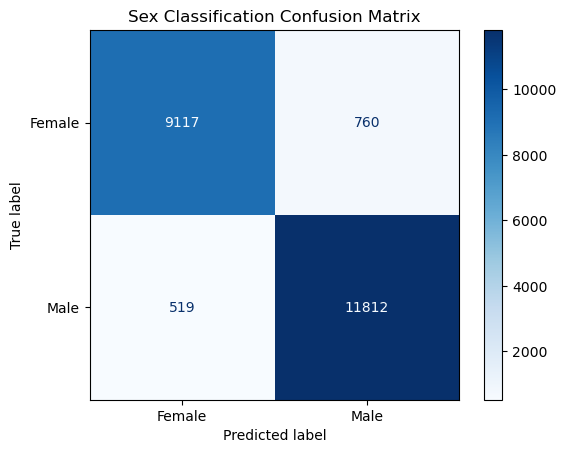

In [18]:
# Plot confusion matrices for sex classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predicted and true labels to arrays
true_sex_labels = [1 if p["TrueSex"] == "Male" else 0 for p in predictions]
pred_sex_labels = [1 if p["PredictedSex"] == "Male" else 0 for p in predictions]

cm = confusion_matrix(true_sex_labels, pred_sex_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
ax = disp.plot(cmap="Blues")

ax.ax_.set_facecolor('none')
ax.ax_.set_title("Sex Classification Confusion Matrix")

plt.savefig("output/confusion_matrix.png", transparent=True, dpi=300)
plt.show()

Ground Truth Sex Distribution (%):
 TrueSex
Male      55.525036
Female    44.474964
Name: proportion, dtype: float64

Predicted Sex Distribution (%):
 PredictedSex
Male      56.610231
Female    43.389769
Name: proportion, dtype: float64


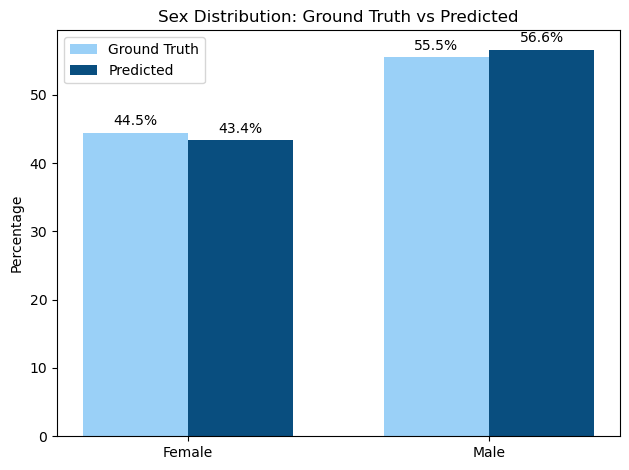

In [19]:
# Sex

# Ground truth
gt_sex_dist = results_df["TrueSex"].value_counts(normalize=True) * 100
# Predicted
pred_sex_dist = results_df["PredictedSex"].value_counts(normalize=True) * 100

print("Ground Truth Sex Distribution (%):\n", gt_sex_dist)
print("\nPredicted Sex Distribution (%):\n", pred_sex_dist)

# Categories
labels = ["Female", "Male"]

# Values
gt_values = gt_sex_dist.loc[labels].values
pred_values = pred_sex_dist.loc[labels].values

# Bar width and positions
x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

# Colors
color_gt = "#9AD0F7"
color_pred = "#094E7F"

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, gt_values, width, label='Ground Truth', color=color_gt)
bars2 = ax.bar(x + width/2, pred_values, width, label='Predicted', color=color_pred)

ax.set_ylabel('Percentage')
ax.set_title('Sex Distribution: Ground Truth vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('output/cohort_sex2.png', transparent=True, dpi=300)
plt.show()

Ground Truth Age Distribution (%):
 True Age Bin
(0, 10]       1.873199
(10, 20]      5.034222
(20, 30]     13.387068
(30, 40]     14.265130
(40, 50]     19.056196
(50, 60]     24.117435
(60, 70]     15.958213
(70, 80]      5.583573
(80, 90]      0.720461
(90, 100]     0.004503
Name: proportion, dtype: float64

Predicted Age Distribution (%):
 Predicted Age Bin
(0, 10]       0.486311
(10, 20]      3.363653
(20, 30]     10.770893
(30, 40]     17.912464
(40, 50]     21.676873
(50, 60]     24.211996
(60, 70]     16.993876
(70, 80]      4.327269
(80, 90]      0.256664
(90, 100]     0.000000
Name: proportion, dtype: float64


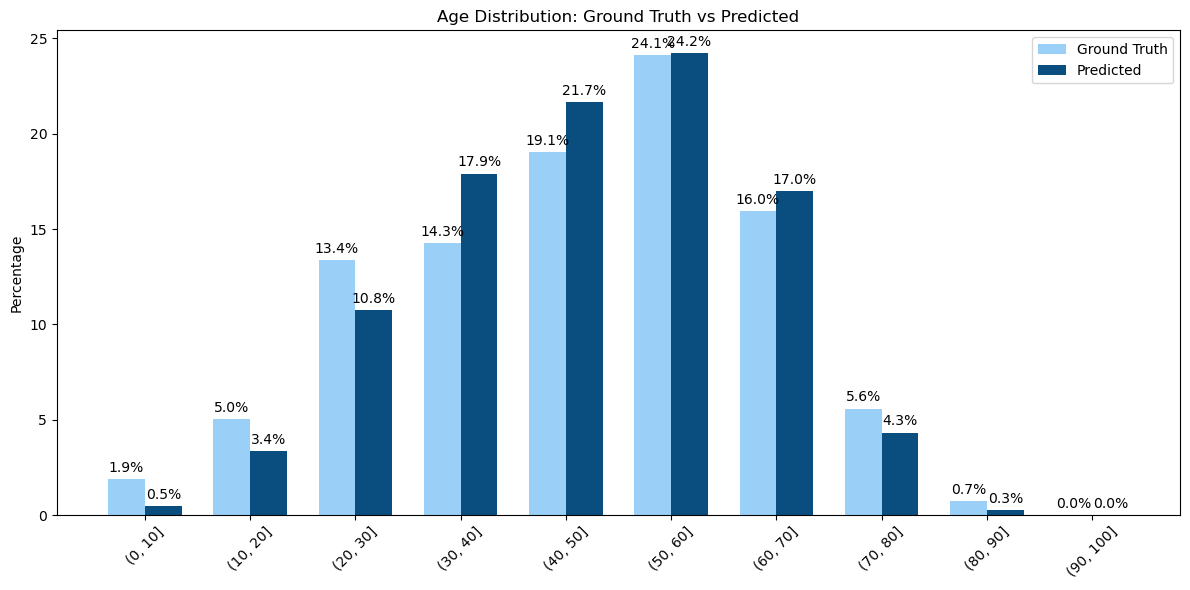

In [20]:
# Age

# Binning for age
bins = np.arange(0, 101, 10)  # 0–10, 10–20, ..., 90–100
results_df["True Age Bin"] = pd.cut(results_df["TrueAge"], bins=bins)
results_df["Predicted Age Bin"] = pd.cut(results_df["PredictedAge"], bins=bins)

# Compute percentage per bin
true_age_dist = results_df["True Age Bin"].value_counts(normalize=True).sort_index() * 100
pred_age_dist = results_df["Predicted Age Bin"].value_counts(normalize=True).sort_index() * 100

print("Ground Truth Age Distribution (%):\n", true_age_dist)
print("\nPredicted Age Distribution (%):\n", pred_age_dist)

# Labels
labels = true_age_dist.index.astype(str)
x = np.arange(len(labels))
width = 0.35

# Colors
color_gt = "#9AD0F7"
color_pred = "#094E7F"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, true_age_dist.values, width, label='Ground Truth', color=color_gt)
bars2 = ax.bar(x + width/2, pred_age_dist.values, width, label='Predicted', color=color_pred)

ax.set_ylabel("Percentage")
ax.set_title("Age Distribution: Ground Truth vs Predicted")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('output/cohort_age2.png', transparent=True, dpi=300)
plt.show()